## Домашнее задание по иммуногеномике. __Basic analysis of antibody sequences__

__ИБ. осень 2020.__
__Чангалиди Антон__

__Использовал IgBlast + Python для обработки данных__

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import operator as op

In [2]:
memory = pd.read_csv('memory.txt', sep = '\t')
naive = pd.read_csv('naive.txt', sep = '\t')
plasma = pd.read_csv('plasma.txt', sep = '\t')

### Task 1.
Analyze the joint usage of V and J genes: for each sequence find the closest germline V and J genes, list of all VJ pairs occurring in the sample, and create a plot (e.g., ​ heatmap​ ) showing the number of sequences for each VJ pair.

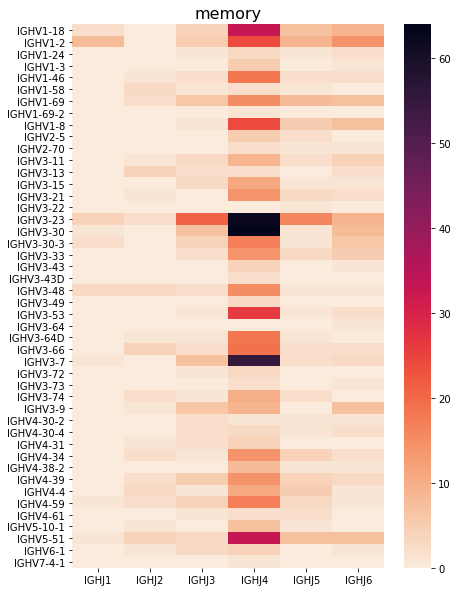

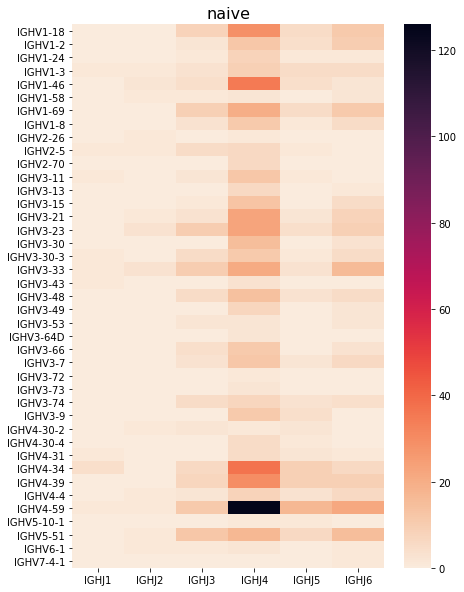

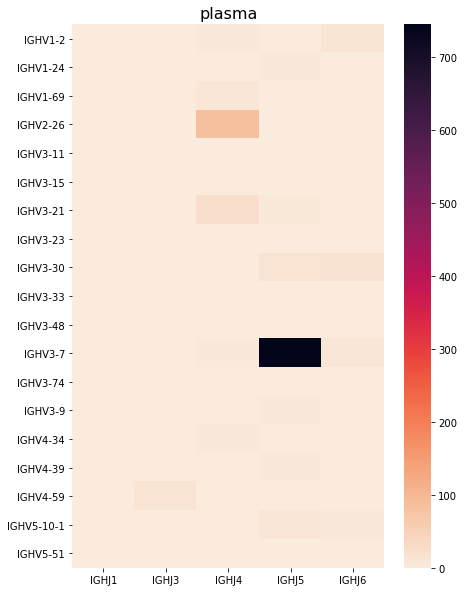

In [3]:
def return_gene(string):
    end = string.find('*')
    return string[:end]

def draw_heatmap(data, name):
    genes_names = ['v_call', 'j_call']
    genes = []
    for gene in genes_names:
        genes.append(data[gene].apply(return_gene).to_list())
    genes = np.array(genes)

    v_map = {j:i for i, j in enumerate(np.unique(genes[0]))}
    j_map = {j:i for i, j in enumerate(np.unique(genes[1]))}
    heatmap = np.zeros((len(v_map), len(j_map)))
    v_genes = {i:0 for i in np.unique(genes[0])}
    for v_gene, j_gene in genes.T:
        v_gene
        heatmap[v_map[v_gene]][j_map[j_gene]]+=1
        v_genes[v_gene] += 1
    fig, ax = plt.subplots(figsize=(7,10))
    ax = sns.heatmap(heatmap, xticklabels=j_map.keys(), yticklabels=v_map.keys(), cmap = sns.cm.rocket_r)
    ax.set_title(name, fontsize=16)
    plt.show()
    return v_genes

datasets = {'memory':memory, 'naive':naive, 'plasma':plasma}
v_genes = {}
for k in datasets:
    v_genes.update({k:draw_heatmap(datasets[k], k)})
    v_genes.update({k:{k: v for k, v in sorted(v_genes[k].items(), key=lambda item: -item[1])}})

In [9]:
memory['v_call']

0         IGHV1-2*02,IGHV1-2*07
1      IGHV3-23*01,IGHV3-23D*01
2                   IGHV4-39*07
3                    IGHV1-2*04
4                   IGHV5-51*01
                 ...           
995                 IGHV3-21*06
996                 IGHV4-59*01
997                IGHV3-64D*09
998                  IGHV1-2*02
999    IGHV3-23*01,IGHV3-23D*01
Name: v_call, Length: 1000, dtype: object

На картинках выше представлен хитмап представленности VJ комбинаций у разных типов имунных клеток (всего 144 VJ-комбинации в naive-клетках, 171 комбинация в memory-клетках, и 32 - в plasma-клетках). У плазматических клеток наблюдается малое число комбинаций (самая представленная комбинация: IGHV3-7 и IGHJ5) - малое число может быть связано с тем, что эти клетки образовались от одной B-клетки с одной V+J комбинацией (направленной на борьбу с одним антигеном). 

В memory и naive клетках самый представленный J-ген - IGHJ4, причем, в memory клетках имеется большее количество комбинаций, чем в других клетках (наверное, из-за того, что эти клетки содержат рецепторы, восприимчивые к различным антигенам).

### Task 2
Find 10 most used V genes in the sample and analyze their ​ mutability ​ . For
each gene, analyze sequences aligned to it and compute the number of
differences in each alignment. Mutability is the distribution of the number of
differences. Visualize mutability of 10 most used V genes in any convenient
form (e.g., using ​ boxplot​ ).

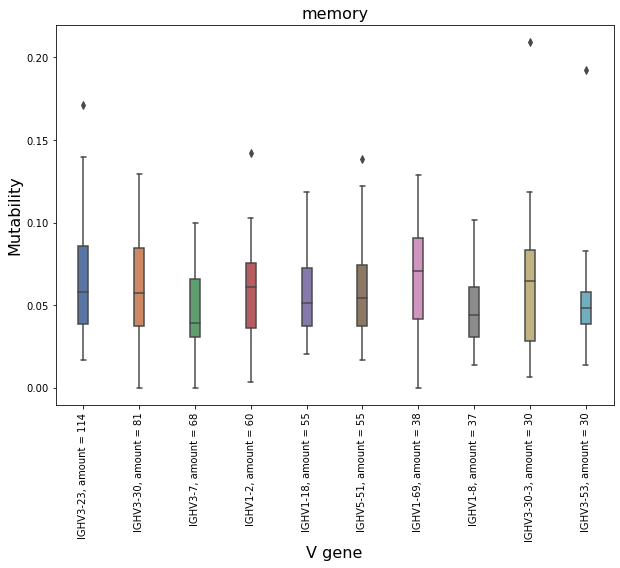

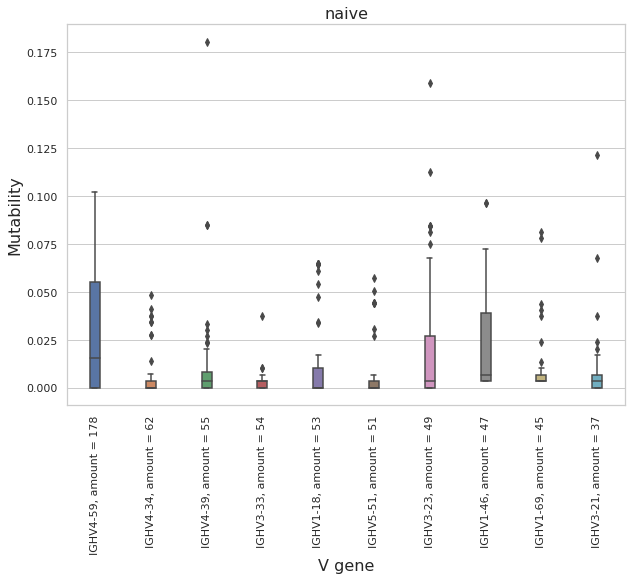

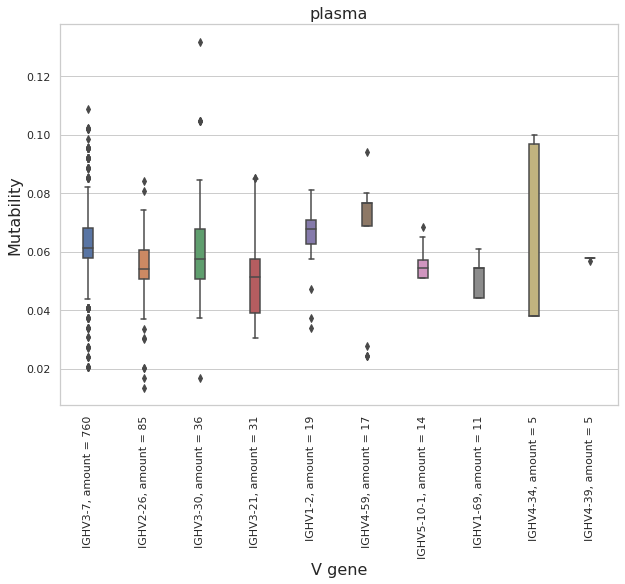

In [4]:
def draw_mutability(data, name):
    def mutability(string1, string2):
        mismatches = 0
        for i, j in zip(string1, string2):
            if i != j:
                mismatches += 1
        return mismatches/len(string1)


    genes = v_genes[name]
    i = 0
    genes_count = {}
    for g in genes:
        i+=1
        genes_count.update({f'{g}, amount = {genes[g]}':[]})
        if i >= 10:
            break
    for row in data.iterrows():
        cur_gene = return_gene(row[1]['v_call'])
        if f'{cur_gene}, amount = {genes[cur_gene]}' in genes_count:
            genes_count[f'{cur_gene}, amount = {genes[cur_gene]}'].append(mutability(row[1]['v_sequence_alignment'], row[1]['v_germline_alignment']))



    plot_data = genes_count

    # sort keys and values together
    sorted_keys, sorted_vals = zip(*(plot_data.items()))

    fig, ax = plt.subplots(figsize=(10,7))
    ax.set_title(name, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    # almost verbatim from question
    sns.set(context='notebook', style='whitegrid')
    sns.utils.axlabel(xlabel="V gene", ylabel="Mutability", fontsize=16)
    sns.boxplot(data=sorted_vals, width=.18)
    # sns.swarmplot(data=sorted_vals, size=6, edgecolor="black", linewidth=.9)

    # category labels
    plt.xticks(plt.xticks()[0], sorted_keys)

    plt.show()
    
    
datasets = {'memory':memory, 'naive':naive, 'plasma':plasma}
for k in datasets:
    draw_mutability(datasets[k], k)

Самый низкий процент мутаций - у наивных клеток. Это логично, так как они еще не прошли профилирование и не имеют "специализации". Мутации возникают в клетках плазмы и памяти - после встречи с антигенами, поэтому эти клетки более изменчивы. При этом, клетки плазмы имеют больший разброс (возможно, из-за того, что им необходимо иметь имунный респонс к большему числу антигенов).

### Task 3
Visualize distributions of CDR3 lengths.

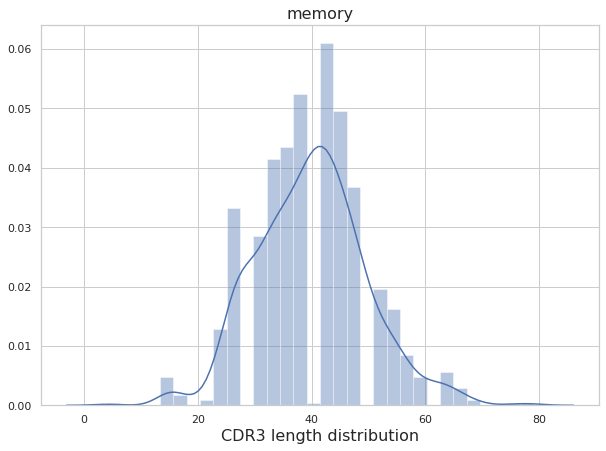

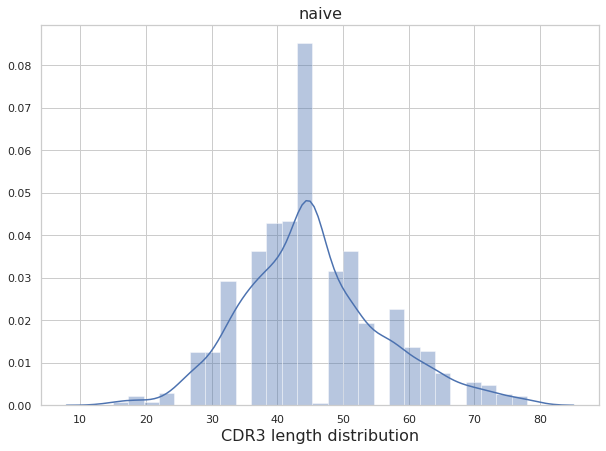

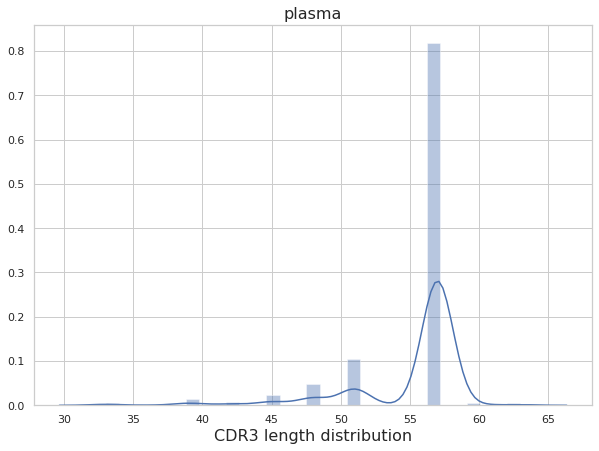

In [5]:
def draw_cdr(data, name):
    cdrs = []
    for row in data.iterrows():
        cdrs.append(len(row[1]['cdr3']))   
    fig, ax = plt.subplots(figsize=(10,7))
    ax.set_title(name, fontsize=16)
    sns.distplot(cdrs)
    sns.utils.axlabel(ylabel = '', xlabel="CDR3 length distribution", fontsize=16)
    plt.show()
    
datasets = {'memory':memory,
            'naive':naive, 
            'plasma':plasma}
for k in datasets:
    draw_cdr(datasets[k], k)

У наивных клеток и клеток памяти схожий пик распределения CDR3 - у 45. Распределние CDR3 клеток плазмы отличается от предыдущих (выделяется 1 пик и почти только он). Скорее всего, это из-за небольшой вариабельности пар V+J генов в этой клетке (выделялась одна), что может значить высокую специфичность к определенному антигену. 

### Task 4
Compute the fraction of non-productive sequences in the sample. Both IgBlast and DiversityAnalyzer report productiveness of input sequences as a part of the output.

In [6]:
def count_non_productive(data, name):
    non_productive_count = 0
    sum_count = 0
    for row in data.iterrows():
        if row[1]['productive'] == 'F':
            non_productive_count += 1
        sum_count += 1
    return non_productive_count / sum_count
    
datasets = {'memory':memory,
            'naive':naive, 
            'plasma':plasma}
for k in datasets:
    print(f'Fraction of non-productive sequences in the {k} sample: {count_non_productive(datasets[k], k)*100}%')

Fraction of non-productive sequences in the memory sample: 7.9%
Fraction of non-productive sequences in the naive sample: 3.1%
Fraction of non-productive sequences in the plasma sample: 3.2%


Процент непродуктивных кеток во всех 3 типах клеток достаточно мало - В клетках памяти мы видим высокий процент непродуктивных последовательностей. Это может быть из-за более низкого отбора и более высокой мутабельностью в этих клетках.